# 1. Data Preparation

In [186]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
import pickle
import random
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import datetime as dt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Adrian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [187]:
#read the data
db = pd.read_csv("data.csv",encoding='cp874')

db.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [188]:
#get the shape of the data
db.shape

(541909, 8)

In [189]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [190]:
#checking the null varibles
db.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

Text(0.5, 1.0, 'Ratio of missing values per columns')

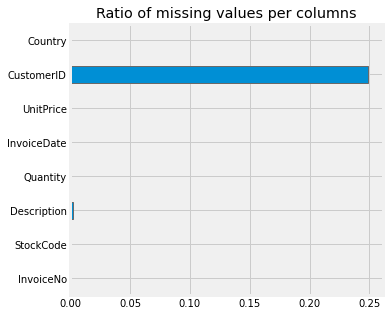

In [191]:
plt.figure(figsize=(5, 5))
db.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

Since we see that we have a lot of missing data on CustomerID and Description tabs we delete the missing lines from the datset since we can not replace or fill them. 

In [192]:
db = db.dropna(subset=["CustomerID"])
db = db.dropna(subset=["Description"])

In [193]:
#checking the null varibles
db.isna().sum().sort_values(ascending=False)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [194]:
#get the shape of the data
db.shape

(406829, 8)

Now that there are no more missing values, we can check for duplicate lines and drop them if there are any.

In [195]:
print('Duplicate lines: {}'.format(db.duplicated().sum()))
db.drop_duplicates(inplace = True)

Duplicate lines: 5225


In [196]:
#get the shape of the data
db.shape

(401604, 8)

In [197]:
#unique data in every column
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(db)

InvoiceNo :  22190
StockCode :  3684
Description :  3896
Quantity :  436
InvoiceDate :  20460
UnitPrice :  620
CustomerID :  4372
Country :  37


# 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

## 2.1 InvoiceNo

In [198]:
#unique invoice numbers
db.InvoiceNo.nunique()

22190

As we know, if the invoice number starts with letter 'c', it indicates a cancellation. Let's see how many cancellations there are.

In [199]:
db["IsCancelled"]=np.where(db.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
db.IsCancelled.value_counts() / db.shape[0] * 100

False    97.790859
True      2.209141
Name: IsCancelled, dtype: float64

From this we can see that 2,2 % of all entries are cancellations. We can drop this values since we are not interested in the returned or cancelled products.

In [200]:
db = db.loc[db.IsCancelled==False].copy()
db = db.drop("IsCancelled", axis=1)

Les't see which invoices has the most items.

Text(0.5, 0, 'InvoiceNo')

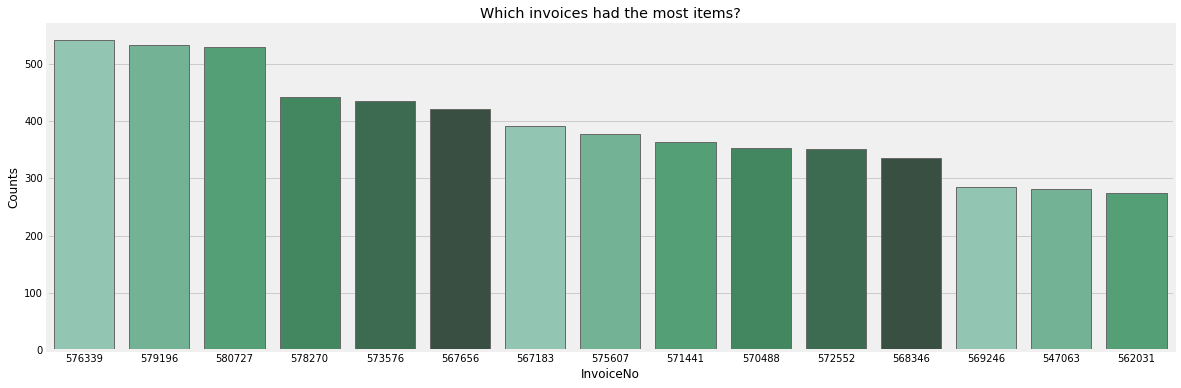

In [201]:
inv_counts = db['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(inv_counts.index, inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xlabel("InvoiceNo")

## 2.2 StockCode

In [202]:
#unique stock codes
db.StockCode.nunique()

3665

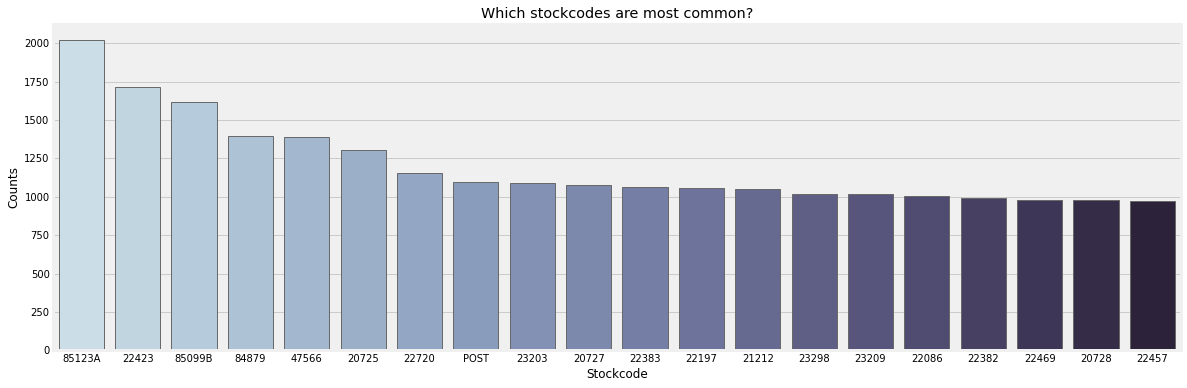

In [203]:
#most common stock codes
stockcode_counts = db.StockCode.value_counts().sort_values(ascending=False)
plt.figure(figsize=(18,6))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            palette="ch:s=.25,rot=-.25")
plt.ylabel("Counts")
plt.xlabel("Stockcode")
plt.title("Which stockcodes are most common?");

## 2.3 Description

In [204]:
#unique description
db.Description.nunique()

3877

Let's see which is the most common description.

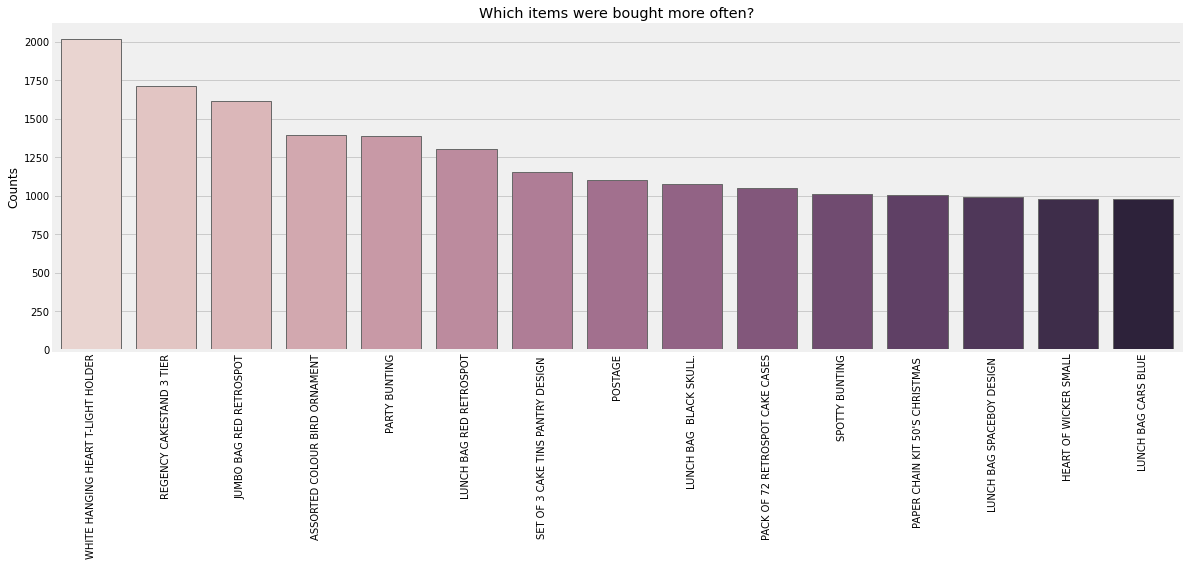

In [205]:
item_counts = db['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

## 2.4 CustomerID

In [206]:
db.CustomerID.nunique()

4339

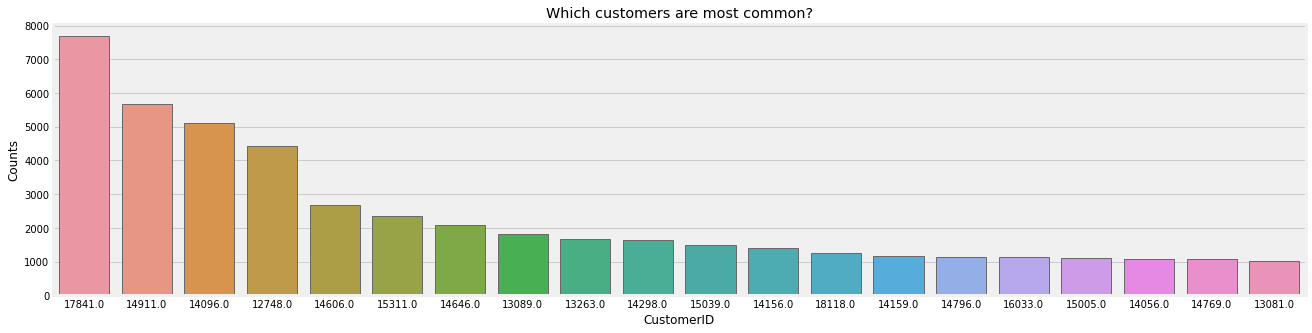

In [207]:
customer_counts = db.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

## 2.5 Countries

Let's see how many different countries we have in the dataset.

In [208]:
db.Country.nunique()

37

We can see that we have 37 unique countries. Let's see how many customers are from each country.

In [209]:
customer_country=db[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3921
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


In [210]:
#how many orders were made in each country
InvoiceNumber_Country = pd.DataFrame(db.groupby(['Country'])['InvoiceNo'].count())

fig = go.Figure(data=go.Choropleth(
                locations=InvoiceNumber_Country.index, # Spatial coordinates
                z = InvoiceNumber_Country['InvoiceNo'].astype(float), # Data to be color-coded
                locationmode = 'country names', # set of locations match entries in `locations`
                colorscale = 'Reds',
                colorbar_title = "Order number",
            ))

fig.update_layout(
    title_text = 'Order number per country',
    geo = dict(showframe = True, projection={'type':'mercator'})
)
fig.layout.template = None
fig.show()

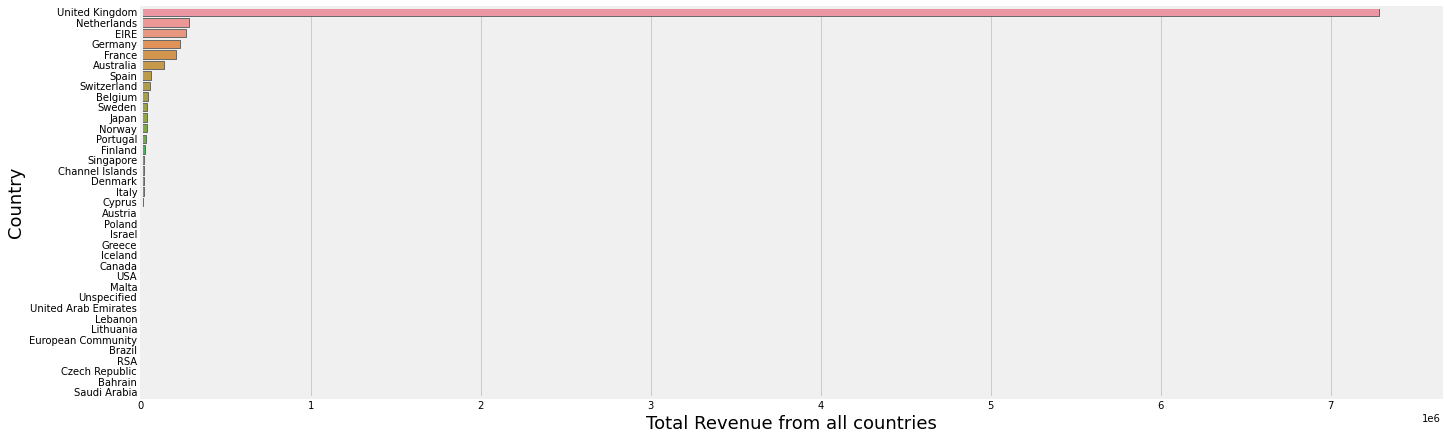

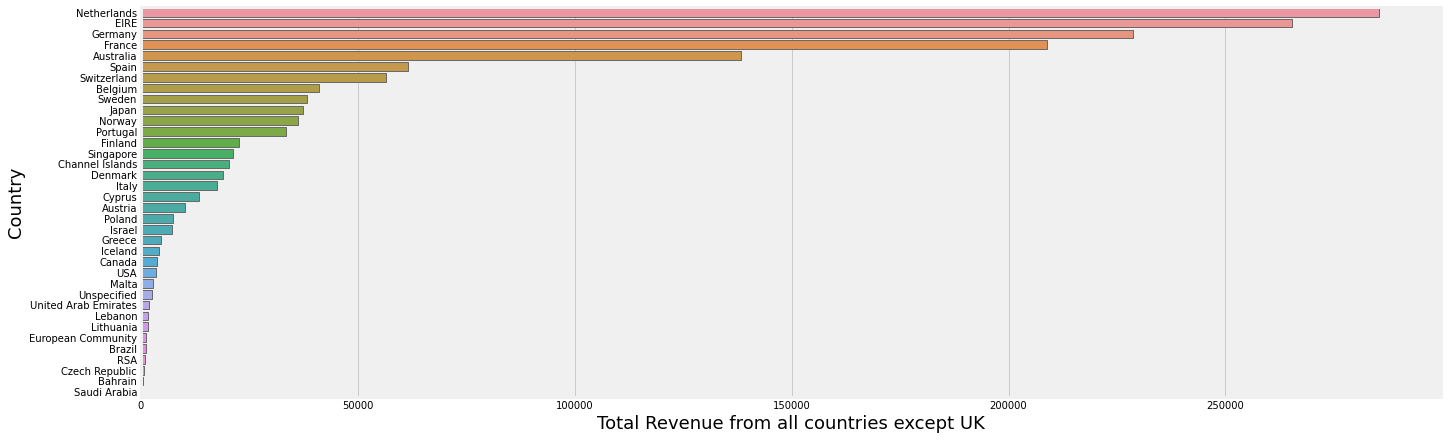

In [211]:
#how much revenue comes from each country
db["Revenue"] = db.Quantity * db.UnitPrice
country_revenue = db.groupby('Country')[['Revenue']].agg(['sum',
                                        'mean',
                                        'median']).sort_values(by=[('Revenue', 'sum')], ascending=False)

fig = plt.figure(constrained_layout=True, figsize=(20, 6))
a = sns.barplot(y=country_revenue.index, x=country_revenue[('Revenue', 'sum')])
plt.xlabel('Total Revenue from all countries', fontsize=18)
plt.ylabel('Country', fontsize=18)


fig = plt.figure(constrained_layout=True, figsize=(20, 6))
country_revenue = country_revenue.drop('United Kingdom')
sns.barplot(y=country_revenue.index, x=country_revenue[('Revenue', 'sum')])
plt.xlabel('Total Revenue from all countries except UK', fontsize=18)
plt.ylabel('Country', fontsize=18)
plt.show()

# 3. Feature engineering

## 3.1 Time feature

In [212]:
#unique invoide dates
db.InvoiceDate.nunique()

17286

In [213]:
db["Revenue"] = db.Quantity * db.UnitPrice
db['InvoiceDate'] = pd.to_datetime(db.InvoiceDate, format='%m/%d/%Y %H:%M')
db["Year"] = db.InvoiceDate.dt.year
db["Quarter"] = db.InvoiceDate.dt.quarter
db["Month"] = db.InvoiceDate.dt.month
db["Week"] = db.InvoiceDate.dt.week
db["Weekday"] = db.InvoiceDate.dt.weekday
db["Weekday"] = db["Weekday"].map( {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
db["Day"] = db.InvoiceDate.dt.day
db["Hour"] = db.InvoiceDate.dt.hour
db["Dayofyear"] = db.InvoiceDate.dt.dayofyear
db["Date"] = pd.to_datetime(db[['Year', 'Month', 'Day']])

In [214]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day","Hour",
                    "StockCode"]

In [215]:
daily_data = pd.DataFrame(db.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = db.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,Hour,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,Wed,335,1,8,10002,48,40.8
1,2010-12-01,2010,4,12,48,Wed,335,1,8,21035,18,53.1
2,2010-12-01,2010,4,12,48,Wed,335,1,8,21724,12,10.2
3,2010-12-01,2010,4,12,48,Wed,335,1,8,21730,6,25.5
4,2010-12-01,2010,4,12,48,Wed,335,1,8,21731,24,39.6


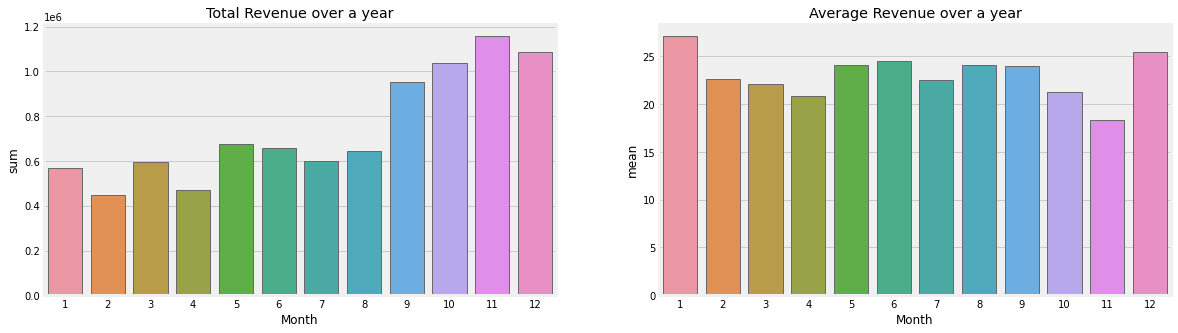

,sum,mean
Month,,
1,568101.310,27.064042
2,446084.920,22.635861
3,594081.760,22.107836
4,468374.331,20.876948
5,677355.150,24.126630
6,660046.050,24.513335
7,598962.901,22.532650
8,644051.040,24.035343
9,950690.202,23.964362


In [216]:
month_sales = db.groupby(['Month'])['Revenue'].agg(['sum','mean'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=month_sales.index, y=month_sales['sum'], ax=axes[0]).set_title("Total Revenue over a year")
plt.ylabel('a')

sns.barplot(x=month_sales.index, y=month_sales['mean'], ax=axes[1]).set_title("Average Revenue over a year")
plt.show()

month_sales

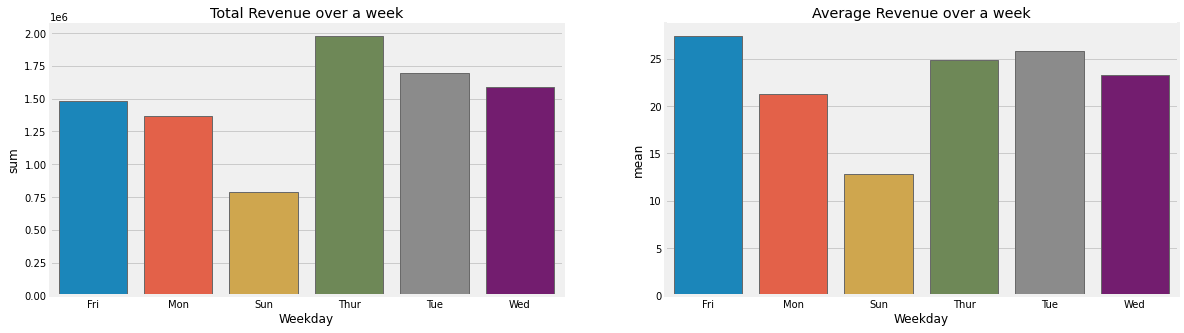

,sum,mean
Weekday,,
Fri,1483080.811,27.347473
Mon,1363604.401,21.227710
Sun,785490.321,12.831874
Thur,1973015.730,24.892956
Tue,1697733.801,25.822225
Wed,1584283.830,23.283568


In [217]:
dayofweek_sales = db.groupby(['Weekday'])['Revenue'].agg(['sum','mean',])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=dayofweek_sales.index, y=dayofweek_sales['sum'], ax=axes[0]).set_title("Total Revenue over a week")
plt.ylabel('a')

sns.barplot(x=dayofweek_sales.index, y=dayofweek_sales['mean'], ax=axes[1]).set_title("Average Revenue over a week")
plt.show()

dayofweek_sales

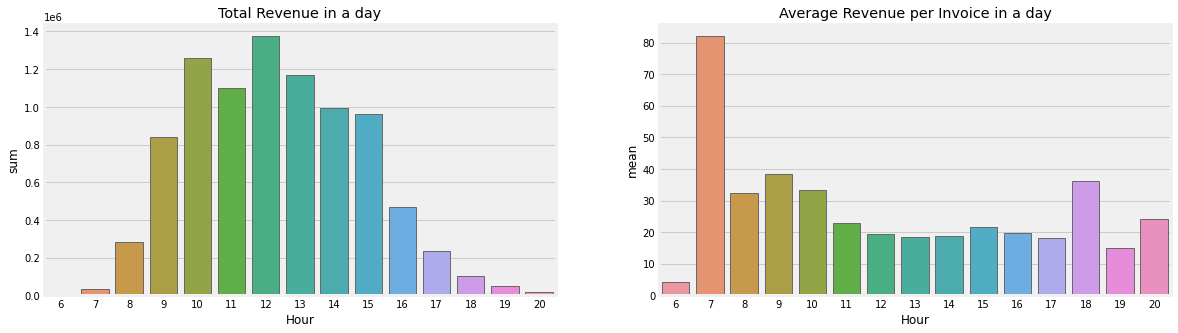

,sum,mean
Hour,,
6,4.250,4.250000
7,31059.210,81.950422
8,281997.790,32.458309
9,842392.341,38.416287
10,1259267.591,33.336005
11,1101177.600,22.764302
12,1373695.390,19.363641
13,1168724.200,18.544113
14,991992.821,18.625475


In [218]:
hour_sales = db.groupby(['Hour'])['Revenue'].agg(['sum','mean'])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=hour_sales.index, y=hour_sales['sum'], ax=axes[0]).set_title("Total Revenue in a day")
plt.ylabel('a')


sns.barplot(x=hour_sales.index, y=hour_sales['mean'], ax=axes[1]).set_title("Average Revenue per Invoice in a day")
plt.show()

hour_sales

## 3.2 RFM Principle

RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

In [219]:
db['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [220]:
db['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [221]:
#fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2011,12,10)
db['InvoiceDate'] = pd.to_datetime(db['InvoiceDate'])

In [222]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Revenue"] = "sum"


rfmTable = db.groupby("InvoiceNo").agg(custom_aggregation)

In [223]:
#add Recency column
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [224]:
rfmTable.head(5)

,InvoiceDate,CustomerID,Revenue,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850.0,139.12,373.0
536366,2010-12-01 08:28:00,17850.0,22.20,373.0
536367,2010-12-01 08:34:00,13047.0,278.73,373.0
536368,2010-12-01 08:34:00,13047.0,70.05,373.0
536369,2010-12-01 08:35:00,13047.0,17.85,373.0


In [225]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["Revenue"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [226]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [227]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346.0,325.0,325.0,1,77183.60
12347.0,2.0,367.0,7,4310.00
12348.0,75.0,358.0,4,1797.24
12349.0,18.0,18.0,1,1757.55
12350.0,310.0,310.0,1,334.40


In [228]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [229]:
segmented_rfm = rfmTable_final

In [230]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [231]:
#apply a score on each feature of RFM
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346.0,325.0,325.0,1,77183.60,4,4,1
12347.0,2.0,367.0,7,4310.00,1,1,1
12348.0,75.0,358.0,4,1797.24,3,2,1
12349.0,18.0,18.0,1,1757.55,2,4,1
12350.0,310.0,310.0,1,334.40,4,4,3


In [232]:
#set a score for each customer in the database
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325.0,325.0,1,77183.60,4,4,1,441
12347.0,2.0,367.0,7,4310.00,1,1,1,111
12348.0,75.0,358.0,4,1797.24,3,2,1,321
12349.0,18.0,18.0,1,1757.55,2,4,1,241
12350.0,310.0,310.0,1,334.40,4,4,3,443


In [233]:
#an example of customers with a score of 111 (best customers)
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646.0,1.0,354.0,74,280206.02,1,1,1,111
18102.0,0.0,367.0,60,259657.30,1,1,1,111
17450.0,8.0,367.0,46,194390.79,1,1,1,111
14911.0,1.0,373.0,201,143711.17,1,1,1,111
14156.0,9.0,371.0,55,117210.08,1,1,1,111
...,...,...,...,...,...,...,...,...
17750.0,5.0,164.0,9,1710.45,1,1,1,111
16775.0,10.0,367.0,11,1691.51,1,1,1,111
13184.0,14.0,290.0,10,1668.95,1,1,1,111


In [234]:
segmented_rfm = segmented_rfm.reset_index()

In [235]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346.0,325.0,325.0,1,77183.60,4,4,1,441
1,12347.0,2.0,367.0,7,4310.00,1,1,1,111
2,12348.0,75.0,358.0,4,1797.24,3,2,1,321
3,12349.0,18.0,18.0,1,1757.55,2,4,1,241
4,12350.0,310.0,310.0,1,334.40,4,4,3,443


In [236]:
db = pd.merge(db,segmented_rfm, on='CustomerID')

In [237]:
db.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue', 'Year', 'Quarter',
       'Month', 'Week', 'Weekday', 'Day', 'Hour', 'Dayofyear', 'Date',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

In [238]:
#since we don't need the quartiles anymore, we will drop them
db = db.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

==> Score's definition

![](https://i.imgur.com/YmItbbm.png?)

## 3.3 Product categories

In [239]:
X = db["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
# we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3877, 1697) of float64


In [240]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3877, 100) of float64


In [241]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

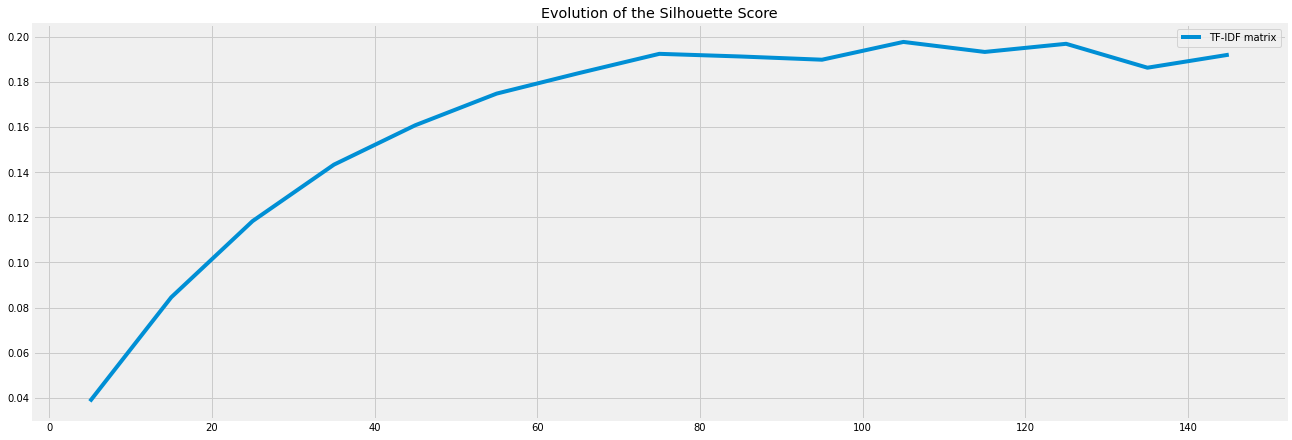

In [242]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

In [243]:
x, score_tfidf

([5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145],
 [0.03838898242244829,
  0.08454037657950501,
  0.11834675924245065,
  0.14338263535104817,
  0.16086300493923852,
  0.17489584327413352,
  0.18389241193148215,
  0.19253597364310318,
  0.1913588758034832,
  0.1899315506404874,
  0.1978199974582363,
  0.19337984119894314,
  0.1969846877133205,
  0.18638356929300473,
  0.19216475261013938])

Since 0.195 is the biggest value, i will choose 95 clusters.

Text(0.5, 1.0, 'ACP with 95 clusters')

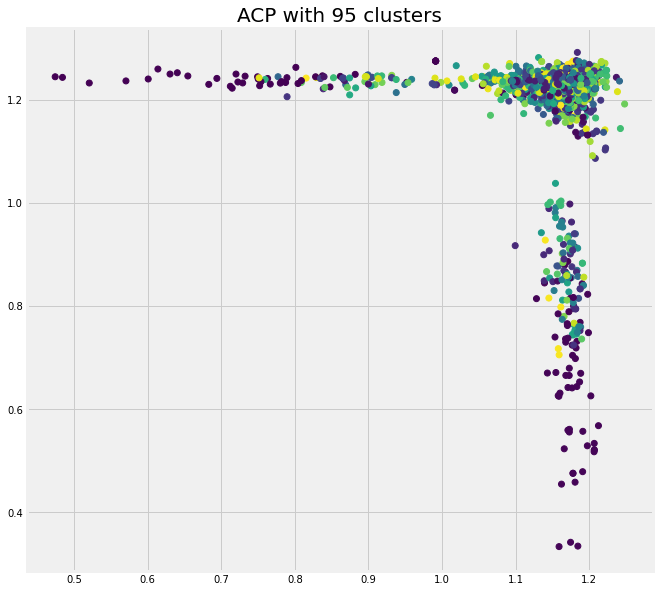

In [244]:
n_clusters = 95

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 95 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

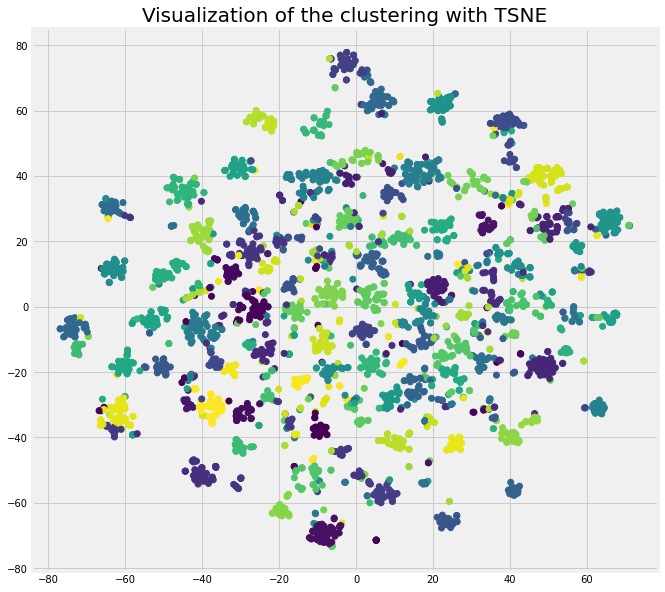

In [245]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

<Figure size 432x288 with 0 Axes>

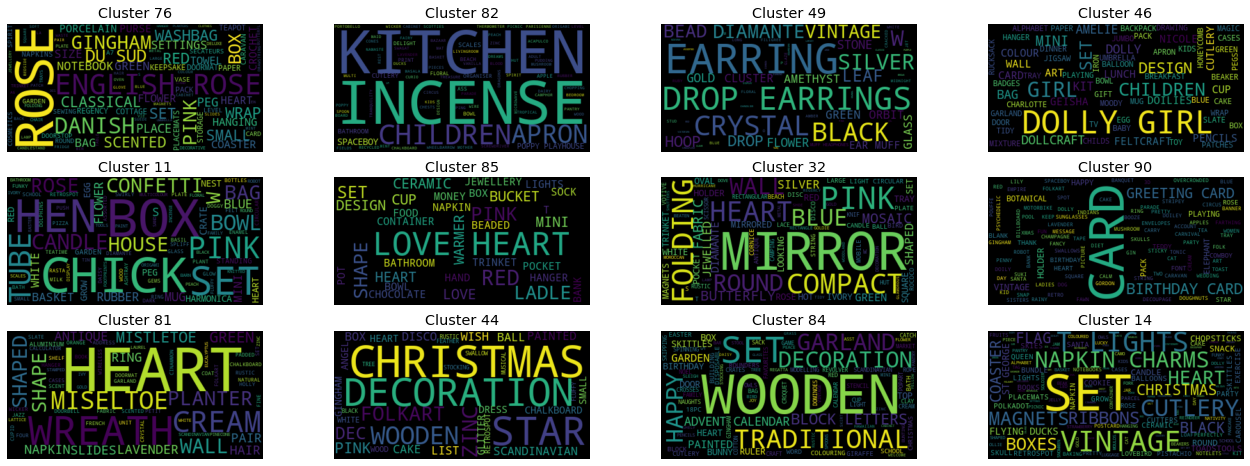

<Figure size 432x288 with 0 Axes>

In [246]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

<AxesSubplot:>

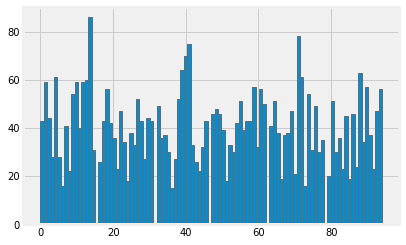

In [247]:
pd.Series(clusters).hist(bins=100)

In [248]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [249]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

# 4. Customer categories

## 4.1 Intermediate dataset grouped by invoices

In [250]:
cluster = db['Description'].apply(lambda x : dict_article_to_cluster[x])
db2 = pd.get_dummies(cluster, prefix="Cluster").mul(db["Revenue"], 0)
db2 = pd.concat([db['InvoiceNo'], db2], axis=1)
db2_grouped = db2.groupby('InvoiceNo').sum()

In [251]:
custom_aggregation = {}
custom_aggregation["Revenue"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


db_grouped = db.groupby("InvoiceNo").agg(custom_aggregation)

## 4.2 Final dataset grouped by customers

In [253]:
db2_grouped_final = pd.concat([db_grouped['CustomerID'], db2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
db2_grouped_final = db2_grouped_final.div(db2_grouped_final.sum(axis=1), axis=0)
db2_grouped_final = db2_grouped_final.fillna(0)

In [254]:
custom_aggregation = {}
custom_aggregation["Revenue"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

db_grouped_final = db_grouped.groupby("CustomerID").agg(custom_aggregation)

In [255]:
db_grouped_final.head(5)

Revenue                        min_recency max_recency frequency  \
                min      max          mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                     
12346.0     77183.6  77183.6  77183.600000       325.0       325.0         1   
12347.0        13.2     45.0     23.308571         2.0       367.0         7   
12348.0        39.6    150.0     82.840000        75.0       358.0         4   
12349.0        15.0     15.0     15.000000        18.0        18.0         1   
12350.0        25.2     25.2     25.200000       310.0       310.0         1   

           monetary_value Quantity         Country  
                 <lambda>      sum        <lambda>  
CustomerID                                          
12346.0          77183.60    74215  United Kingdom  
12347.0           4310.00     2458         Iceland  
12348.0           1797.24     2341         Finland  
12349.0           1757.55      631           Italy  
12350.0            334.40      197          Norway

In [256]:
db_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [257]:
db_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346.0,77183.6,77183.6,77183.600000,325.0,325.0,1,77183.60,74215,United Kingdom
12347.0,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,Iceland
12348.0,39.6,150.0,82.840000,75.0,358.0,4,1797.24,2341,Finland
12349.0,15.0,15.0,15.000000,18.0,18.0,1,1757.55,631,Italy
12350.0,25.2,25.2,25.200000,310.0,310.0,1,334.40,197,Norway


In [258]:
db2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
12347.0,0.046775,0.023596,0.0,0.0,0.0,0.0,0.003132,0.010858,0.0,0.0,...,0.003884,0.000000,0.000000,0.0,0.003852,0.089722,0.0,0.0,0.000000,0.101717
12348.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.096815,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
12349.0,0.000000,0.010071,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.041137,0.004438,0.016130,0.0,0.000000,0.000000,0.0,0.0,0.009388,0.000000
12350.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


## 4.3 Clustering customers

In [263]:
db_grouped_final = db_grouped_final.drop(columns=['country'])

In [264]:
X1 = db_grouped_final.values
X2 = db2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [271]:
x = list(range(2, 11))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.9719477519706626 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8927385019331069 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.32895089131738386 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.4426580500120454 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.44261723311962975 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4475303564102151 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.4446989658888673 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4480637428876699 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.4402496050401161 with Std Scaling


# 5. Classification of customers

In [356]:
kmeans = KMeans(init='k-means++', n_clusters = 7, n_init=30, random_state=0)
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

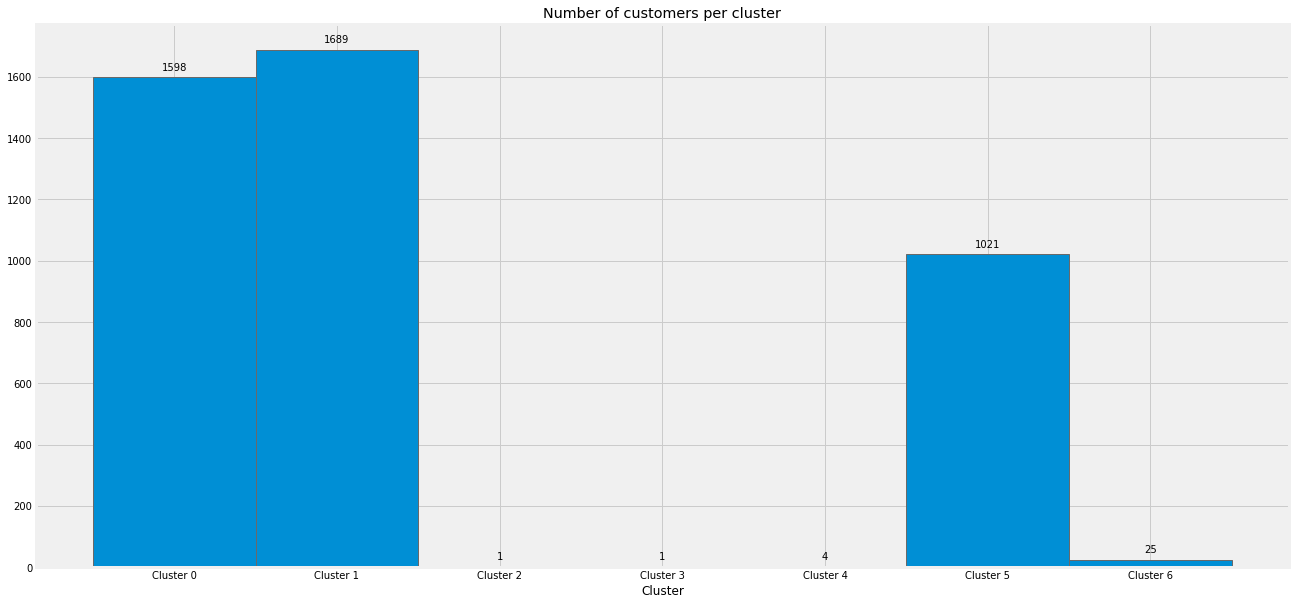

In [357]:
plt.figure(figsize = (20,10))
n, bins, patches = plt.hist(clusters, bins=7)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [358]:
db_grouped_final["cluster"] = clusters

In [359]:
final_dataset = pd.concat([db_grouped_final, db2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,77183.6,77183.6,77183.600000,325.0,325.0,1,77183.60,74215,2,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
12347.0,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,1,0.046775,...,0.003884,0.000000,0.000000,0.0,0.003852,0.089722,0.0,0.0,0.000000,0.101717
12348.0,39.6,150.0,82.840000,75.0,358.0,4,1797.24,2341,1,0.000000,...,0.000000,0.000000,0.096815,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
12349.0,15.0,15.0,15.000000,18.0,18.0,1,1757.55,631,0,0.000000,...,0.041137,0.004438,0.016130,0.0,0.000000,0.000000,0.0,0.0,0.009388,0.000000
12350.0,25.2,25.2,25.200000,310.0,310.0,1,334.40,197,5,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [360]:
final_dataset_V2 = final_dataset.reset_index()

In [361]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [362]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(db, f)

## 5.1 Interpreting the clusters

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

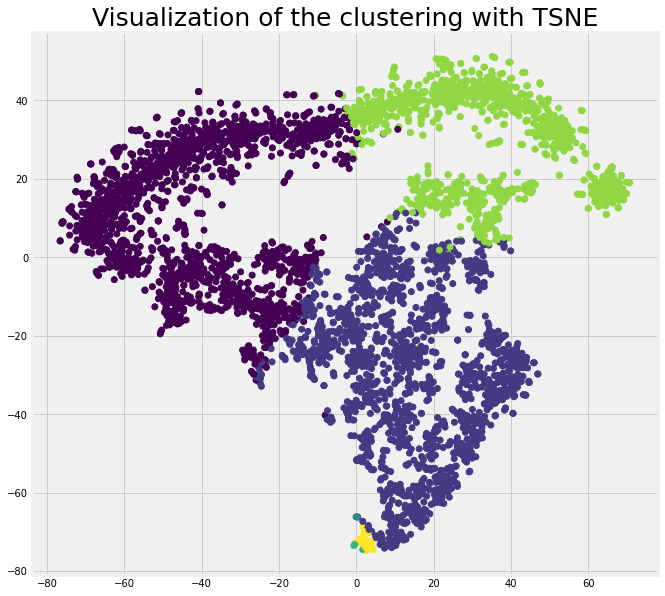

In [366]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

### 5.1.1 Cluster 0

In [428]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94
CustomerID,,,,,,,,,,,,,,,,,,,,,
12349.0,15.00,15.00,15.000000,18.0,18.0,1,1757.55,631,0,0.000000,...,0.041137,0.004438,0.016130,0.0,0.000000,0.000000,0.000000,0.000000,0.009388,0.000000
12357.0,19.80,19.80,19.800000,33.0,33.0,1,6207.67,2708,0,0.016354,...,0.024473,0.000000,0.011502,0.0,0.010954,0.025981,0.004833,0.000000,0.009665,0.000000
12358.0,15.00,142.80,78.900000,1.0,150.0,2,1168.06,248,0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12360.0,10.20,20.80,15.433333,52.0,200.0,3,2662.06,1165,0,0.000000,...,0.000000,0.006762,0.000000,0.0,0.000000,0.007573,0.013298,0.007513,0.010218,0.020698
12364.0,10.20,45.00,20.175000,7.0,112.0,4,1313.10,1506,0,0.030158,...,0.000000,0.040896,0.007996,0.0,0.000000,0.015353,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18276.0,99.00,99.00,99.000000,43.0,43.0,1,335.86,186,0,0.030370,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18277.0,17.85,17.85,17.850000,58.0,58.0,1,110.38,68,0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18278.0,17.00,17.00,17.000000,73.0,73.0,1,173.90,66,0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [429]:
final_dataset[final_dataset['cluster']==0].mean()

min            28.852140
max            54.044437
mean           40.304136
min_recency    49.605757
max_recency    87.442428
                 ...    
Cluster_90      0.010867
Cluster_91      0.010434
Cluster_92      0.004005
Cluster_93      0.012055
Cluster_94      0.036403
Length: 104, dtype: float64

In [430]:
temp_final_df = final_dataset.reset_index()

In [431]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [434]:
cluster0 = db[db['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'Revenue', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity             9.641747
UnitPrice            2.969088
Revenue             15.264481
frequency            3.061048
min_recency         36.631440
monetary_value    1311.029634
dtype: float64

In [435]:
cluster0['Description'].value_counts()[:10]

BAKING SET 9 PIECE RETROSPOT          302
PAPER CHAIN KIT 50'S CHRISTMAS        274
WHITE HANGING HEART T-LIGHT HOLDER    260
ASSORTED COLOUR BIRD ORNAMENT         251
REGENCY CAKESTAND 3 TIER              246
POSTAGE                               234
RABBIT NIGHT LIGHT                    227
REX CASH+CARRY JUMBO SHOPPER          221
HOT WATER BOTTLE KEEP CALM            219
SPOTTY BUNTING                        206
Name: Description, dtype: int64

In [436]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [437]:
cluster0_grouped['RFMScore'].value_counts()

344    210
244    147
343    136
243     94
222     70
122     68
144     63
233     59
342     54
333     51
133     50
332     47
132     40
232     40
121     37
234     33
111     33
143     31
223     30
123     29
134     28
444     26
221     21
322     21
323     19
334     19
443     19
242     18
341     15
112     11
124      8
321      7
331      7
231      6
434      5
324      5
131      5
142      5
211      5
241      4
224      4
433      4
442      3
311      2
441      2
212      2
421      1
141      1
424      1
431      1
423      1
Name: RFMScore, dtype: int64

In [438]:
cluster0_grouped['Country'].value_counts()

United Kingdom          1431
Germany                   40
France                    31
Spain                     10
Switzerland                9
Finland                    8
Belgium                    8
Norway                     7
Portugal                   7
Italy                      6
Austria                    5
Denmark                    5
Sweden                     4
Poland                     3
Japan                      3
USA                        3
Canada                     2
Malta                      2
Unspecified                2
Cyprus                     2
Israel                     2
Netherlands                2
Channel Islands            2
United Arab Emirates       1
Australia                  1
Greece                     1
RSA                        1
Name: Country, dtype: int64

In [439]:
cluster0['Month'].value_counts()

11    22118
10    18191
9     11924
8      5990
7      5655
12     5302
6      3541
5      1598
Name: Month, dtype: int64

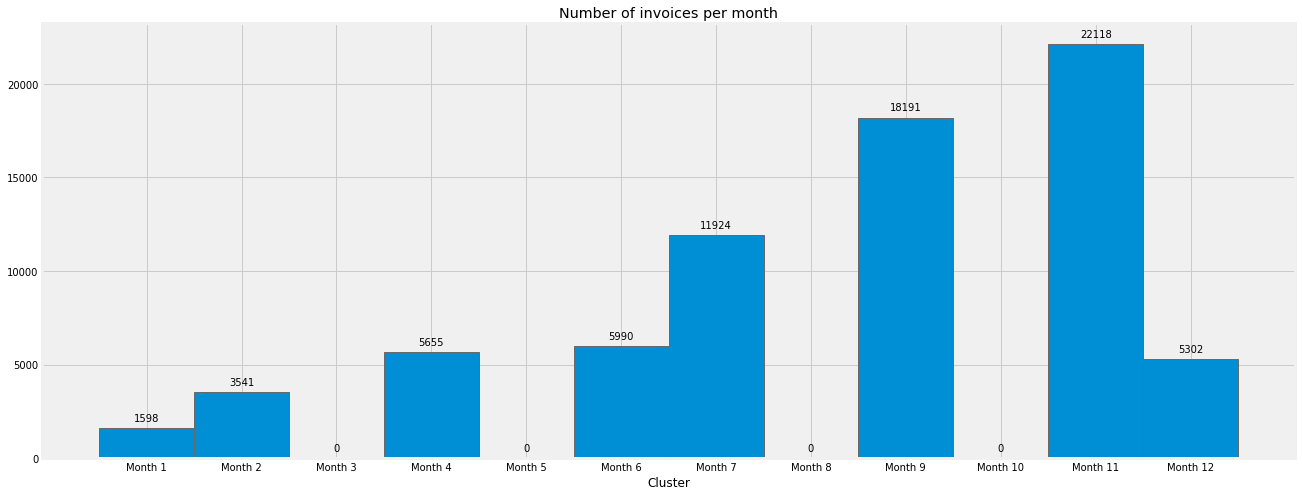

In [440]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [441]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

Series([], Name: Year, dtype: int64)

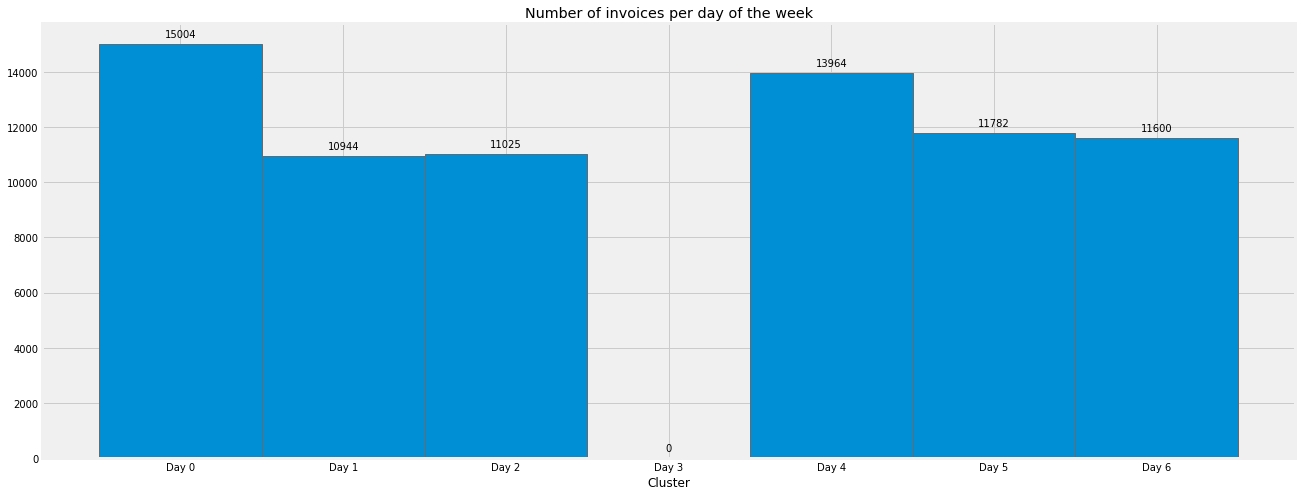

In [442]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [443]:
cluster0['Day'].nunique()

31

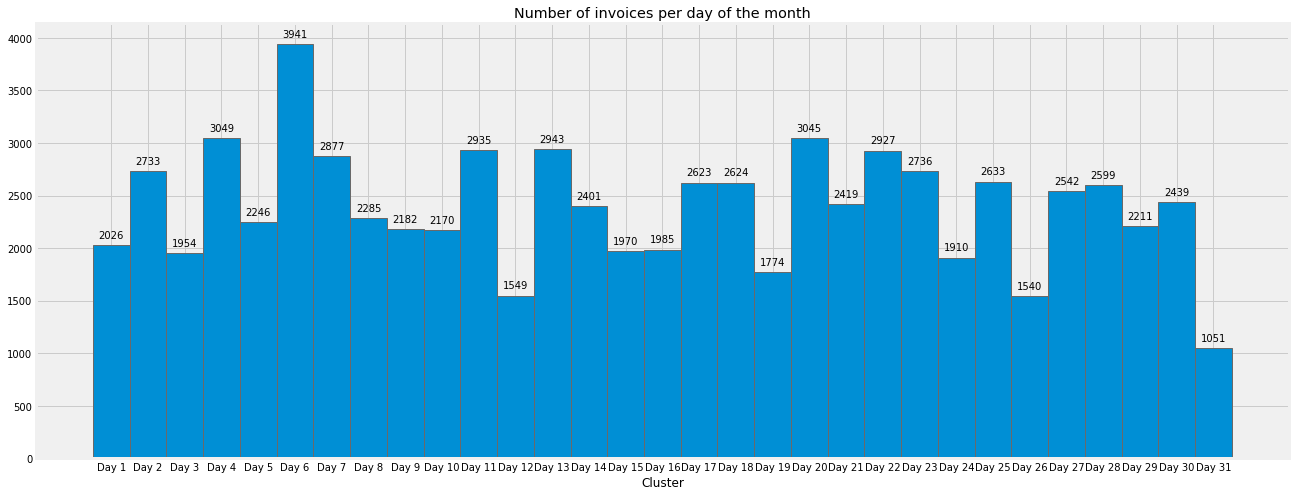

In [444]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [445]:
cluster0['Hour'].nunique()

15

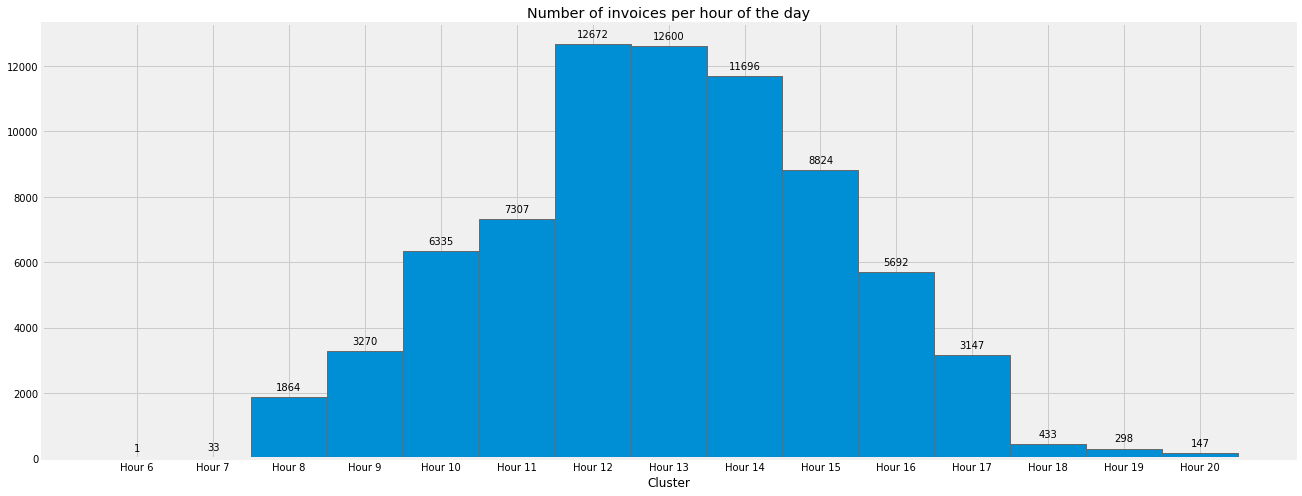

In [446]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=15)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

Key figures: 
* Min Basket Price:  28.85
* Mean Basket Price: 54.04
* Max Basket Price:  40.30

* Quantity:            9.64
* UnitPrice:           2.96
* Revenue:             15.26
* Frequency            3.06
* Recency              36.63

TOP 10 bought products :

* BAKING SET 9 PIECE RETROSPOT          302
* PAPER CHAIN KIT 50'S CHRISTMAS        274
* WHITE HANGING HEART T-LIGHT HOLDER    260
* ASSORTED COLOUR BIRD ORNAMENT         251
* REGENCY CAKESTAND 3 TIER              246
* POSTAGE                               234
* RABBIT NIGHT LIGHT                    227
* REX CASH+CARRY JUMBO SHOPPER          221
* HOT WATER BOTTLE KEEP CALM            219
* SPOTTY BUNTING                        206

### 5.1.2 Cluster 1

In [410]:
final_dataset[final_dataset['cluster']==1]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,13.20,45.00,23.308571,2.0,367.0,7,4310.00,2458,1,0.046775,...,0.003884,0.000000,0.000000,0.000000,0.003852,0.089722,0.000000,0.000000,0.000000,0.101717
12348.0,39.60,150.00,82.840000,75.0,358.0,4,1797.24,2341,1,0.000000,...,0.000000,0.000000,0.096815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12352.0,9.90,376.50,67.037500,36.0,296.0,8,2506.04,536,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.335310,0.000000,0.000000,0.004150,0.000000,0.000000
12356.0,25.50,102.00,51.300000,22.0,325.0,3,2811.43,1591,1,0.008394,...,0.068719,0.025325,0.012378,0.000000,0.000000,0.000000,0.010671,0.000000,0.000000,0.000000
12359.0,10.00,34.00,20.175000,57.0,331.0,4,6310.03,1609,1,0.024485,...,0.000000,0.000000,0.002829,0.000000,0.028375,0.003994,0.000000,0.006339,0.089461,0.034913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18263.0,15.00,30.60,21.920000,25.0,252.0,3,1213.16,1468,1,0.068746,...,0.015431,0.000000,0.000000,0.000000,0.000000,0.066768,0.000000,0.032972,0.057470,0.000000
18270.0,19.80,33.20,26.500000,38.0,266.0,2,283.15,101,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18272.0,6.64,18.72,13.053333,2.0,246.0,6,3078.58,2050,1,0.000000,...,0.005749,0.000000,0.036299,0.000000,0.003274,0.004872,0.034886,0.000000,0.000000,0.000000


In [411]:
final_dataset[final_dataset['cluster']==1].mean()

min             15.489355
max            122.988437
mean            49.752321
min_recency     37.011841
max_recency    312.342806
                  ...    
Cluster_90       0.009886
Cluster_91       0.012296
Cluster_92       0.002436
Cluster_93       0.009081
Cluster_94       0.044254
Length: 104, dtype: float64

In [412]:
temp_final_df = final_dataset.reset_index()

In [413]:
cust1 = list(temp_final_df[temp_final_df['cluster']==1]['CustomerID'])

In [414]:
cluster1 = db[db['CustomerID'].isin(cust1)]
cluster1[['Quantity', 'UnitPrice', 'Revenue', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity            11.068575
UnitPrice            3.056948
Revenue             19.420136
frequency           11.124285
min_recency         24.931772
monetary_value    4741.400720
dtype: float64

In [415]:
cluster1['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    1377
JUMBO BAG RED RETROSPOT               1177
REGENCY CAKESTAND 3 TIER              1102
LUNCH BAG RED RETROSPOT                993
PARTY BUNTING                          981
ASSORTED COLOUR BIRD ORNAMENT          961
LUNCH BAG  BLACK SKULL.                789
SET OF 3 CAKE TINS PANTRY DESIGN       767
POSTAGE                                754
LUNCH BAG SPACEBOY DESIGN              720
Name: Description, dtype: int64

In [416]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster1_grouped = cluster1.groupby("CustomerID").agg(custom_aggregation)

In [417]:
cluster1_grouped['RFMScore'].value_counts()

111    396
211    179
322    138
222    120
122    105
321     80
221     75
311     68
112     53
323     52
121     50
212     45
223     43
332     42
333     41
233     32
312     24
123     23
133     21
334     19
232     18
234     16
132      8
231      6
134      6
331      5
324      4
421      3
224      3
113      3
411      3
422      2
124      2
313      1
424      1
412      1
114      1
Name: RFMScore, dtype: int64

In [418]:
cluster1_grouped['Country'].value_counts()

United Kingdom     1541
Germany              38
France               37
Spain                13
Belgium              10
Portugal              6
Switzerland           6
Australia             6
Italy                 4
Channel Islands       4
Netherlands           3
Finland               3
Cyprus                3
Denmark               3
Poland                2
Japan                 2
Norway                2
Sweden                2
Singapore             1
Unspecified           1
Czech Republic        1
Iceland               1
Name: Country, dtype: int64

In [419]:
cluster1['Month'].value_counts()

11    33748
12    27337
10    25247
9     23070
3     19921
5     19893
8     18047
6     17430
7     17105
4     16695
1     15361
2     14254
Name: Month, dtype: int64

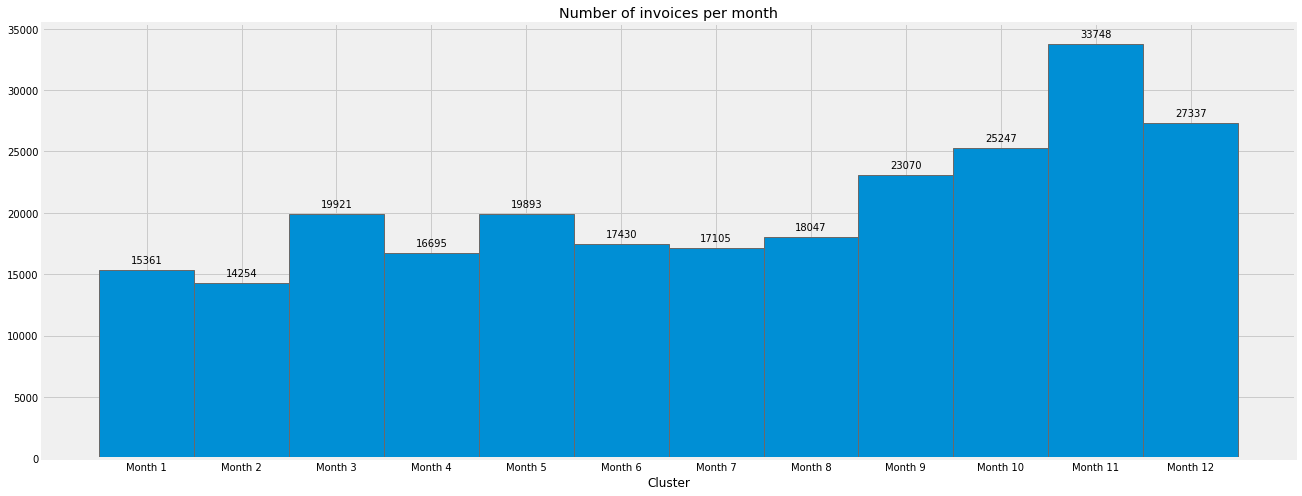

In [420]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [421]:
temp['Year'] = cluster1[cluster1['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    1137
2011.0     436
Name: Year, dtype: int64

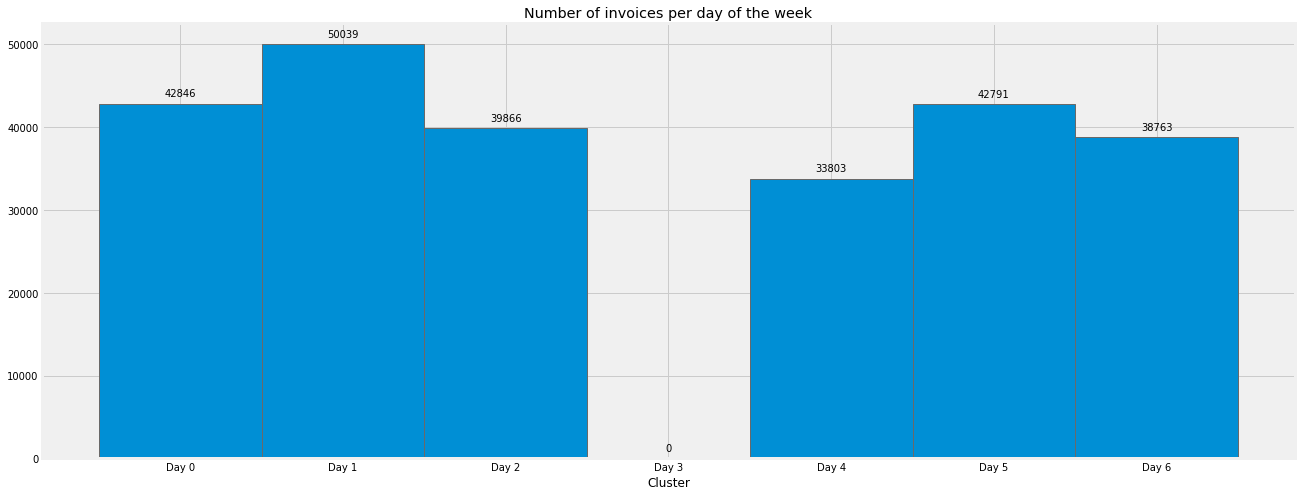

In [422]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [423]:
cluster1['Day'].nunique()

31

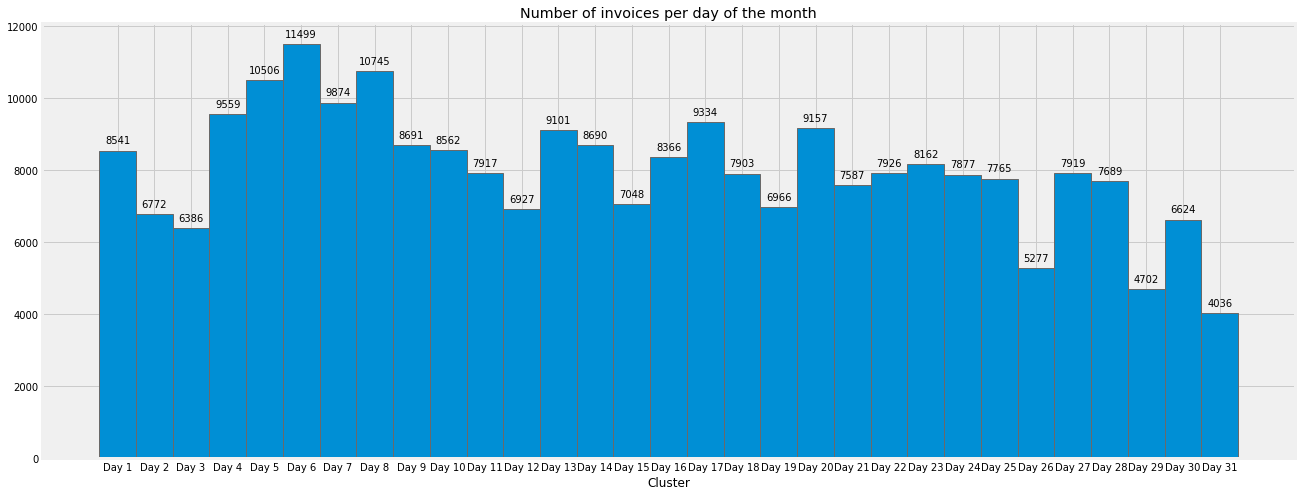

In [424]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [425]:
cluster1['Hour'].nunique()

14

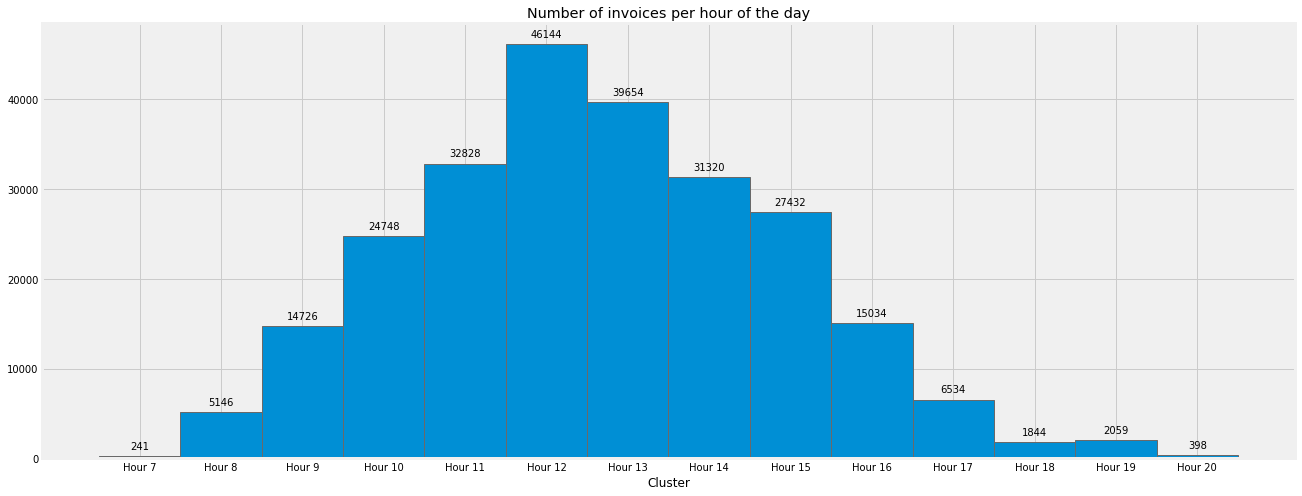

In [427]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster1['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster1['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

Key figures: 
* Min Basket Price:  15.48
* Mean Basket Price: 122.98
* Max Basket Price:  49.75

* Quantity:          11.06
* UnitPrice:         3.05
* Revenue:           19.42
* Frequency          11.12
* Recency            24.93

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER    1377
* JUMBO BAG RED RETROSPOT               1177
* REGENCY CAKESTAND 3 TIER              1102
* LUNCH BAG RED RETROSPOT                993
* PARTY BUNTING                          981
* ASSORTED COLOUR BIRD ORNAMENT          961
* LUNCH BAG  BLACK SKULL.                789
* SET OF 3 CAKE TINS PANTRY DESIGN       767
* POSTAGE                                754
* LUNCH BAG SPACEBOY DESIGN              720

### 5.1.3 Cluster 5

In [464]:
final_dataset[final_dataset['cluster']==5]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_85,Cluster_86,Cluster_87,Cluster_88,Cluster_89,Cluster_90,Cluster_91,Cluster_92,Cluster_93,Cluster_94
CustomerID,,,,,,,,,,,,,,,,,,,,,
12350.0,25.20,25.20,25.200,310.0,310.0,1,334.40,197,5,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12353.0,19.90,19.90,19.900,204.0,204.0,1,89.00,20,5,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12354.0,20.80,20.80,20.800,232.0,232.0,1,1079.40,530,5,0.000000,...,0.0,0.016398,0.01612,0.0,0.000000,0.009339,0.000000,0.000000,0.016537,0.027145
12355.0,30.00,30.00,30.000,214.0,214.0,1,459.40,240,5,0.115586,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12361.0,23.40,23.40,23.400,287.0,287.0,1,189.90,91,5,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.086888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18250.0,14.85,14.85,14.850,310.0,310.0,1,349.27,199,5,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.042947,0.000000,0.042517,0.000000
18260.0,15.00,39.60,25.095,172.0,358.0,6,2628.35,1475,5,0.048966,...,0.0,0.084235,0.01324,0.0,0.009474,0.012023,0.011072,0.000000,0.000000,0.000000
18269.0,18.60,18.60,18.600,366.0,366.0,1,168.60,76,5,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.120996,0.000000,0.000000


In [465]:
final_dataset[final_dataset['cluster']==5].mean()

min             32.989941
max             51.308776
mean            41.480942
min_recency    251.790402
max_recency    282.573947
                  ...    
Cluster_90       0.007910
Cluster_91       0.015345
Cluster_92       0.002363
Cluster_93       0.010690
Cluster_94       0.029714
Length: 104, dtype: float64

In [466]:
temp_final_df = final_dataset.reset_index()

In [467]:
cust5 = list(temp_final_df[temp_final_df['cluster']==5]['CustomerID'])

In [468]:
cluster5 = db[db['CustomerID'].isin(cust5)]
cluster5[['Quantity', 'UnitPrice', 'Revenue', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity            9.488872
UnitPrice           3.506861
Revenue            17.262656
frequency           2.603877
min_recency       236.892072
monetary_value    941.650489
dtype: float64

In [469]:
cluster5['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    228
REGENCY CAKESTAND 3 TIER              200
PARTY BUNTING                         144
ASSORTED COLOUR BIRD ORNAMENT         132
JAM MAKING SET WITH JARS              112
NATURAL SLATE HEART CHALKBOARD        105
SET OF 3 CAKE TINS PANTRY DESIGN      105
REX CASH+CARRY JUMBO SHOPPER          102
HEART OF WICKER SMALL                  97
PACK OF 72 RETROSPOT CAKE CASES        93
Name: Description, dtype: int64

In [470]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster5_grouped = cluster5.groupby("CustomerID").agg(custom_aggregation)

In [471]:
cluster5_grouped['RFMScore'].value_counts()

444    415
443    206
433     95
432     59
434     56
422     44
423     39
442     36
421     15
424     11
431     11
441      8
411      7
412      6
322      3
333      2
413      2
323      2
321      1
414      1
332      1
334      1
Name: RFMScore, dtype: int64

In [472]:
cluster5_grouped['Country'].value_counts()

United Kingdom          923
France                   19
Germany                  16
Belgium                   6
Portugal                  6
Switzerland               5
Spain                     5
Italy                     4
Austria                   4
Greece                    3
Japan                     3
Netherlands               3
Channel Islands           3
Bahrain                   2
Canada                    2
Cyprus                    2
Finland                   1
Poland                    1
Lithuania                 1
Saudi Arabia              1
EIRE                      1
Norway                    1
United Arab Emirates      1
USA                       1
Israel                    1
Lebanon                   1
Australia                 1
Sweden                    1
Brazil                    1
European Community        1
Unspecified               1
Name: Country, dtype: int64

In [473]:
cluster5['Month'].value_counts()

12    5406
3     4647
5     3966
4     3828
1     3723
2     3489
6     3190
7      999
8        3
Name: Month, dtype: int64

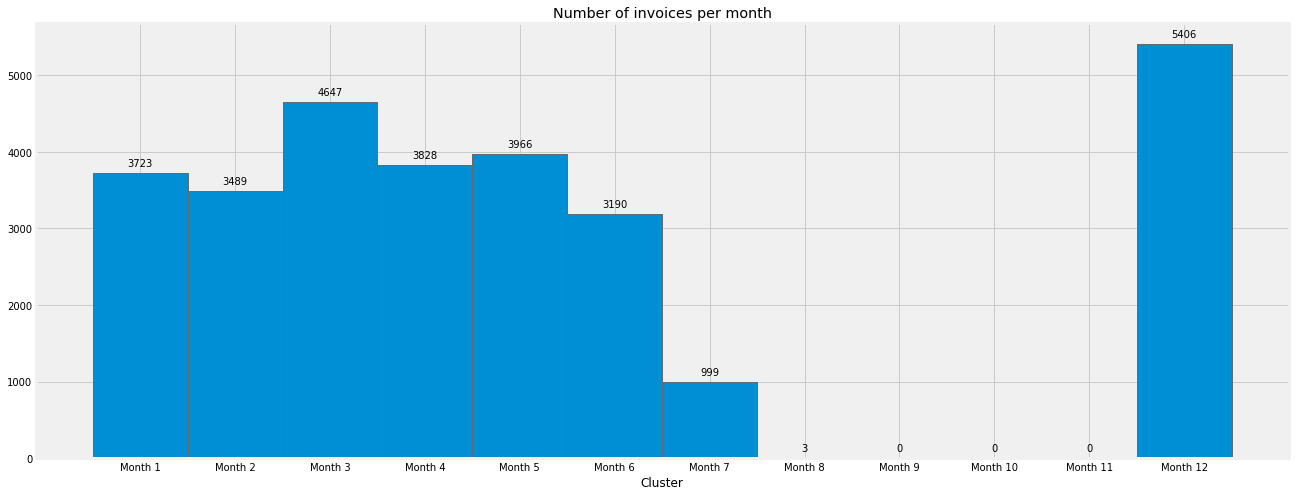

In [474]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [475]:
temp['Year'] = cluster5[cluster5['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    702
Name: Year, dtype: int64

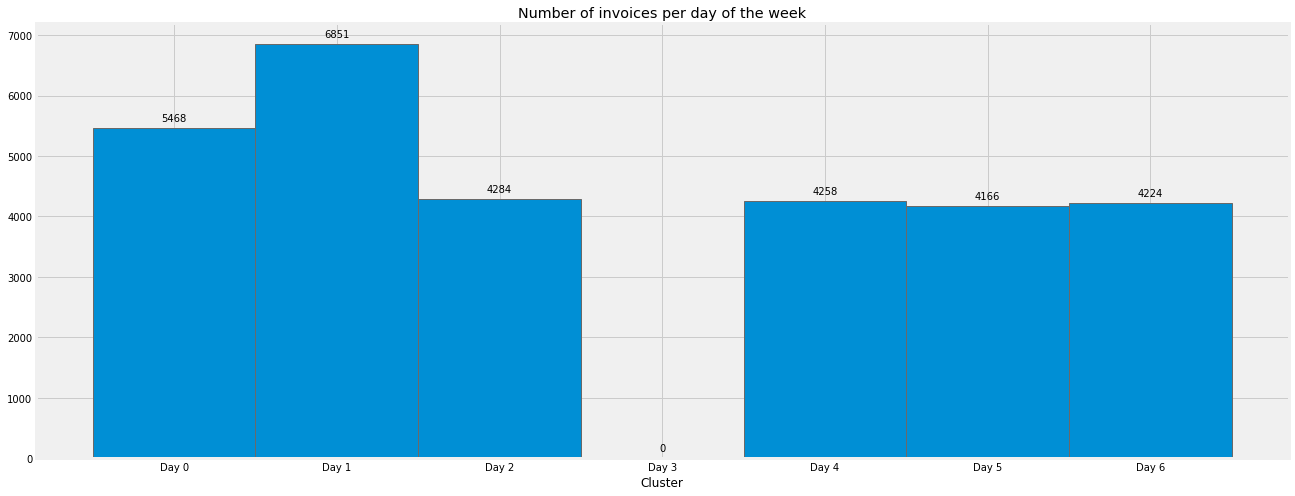

In [476]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [477]:
cluster5['Day'].nunique()

31

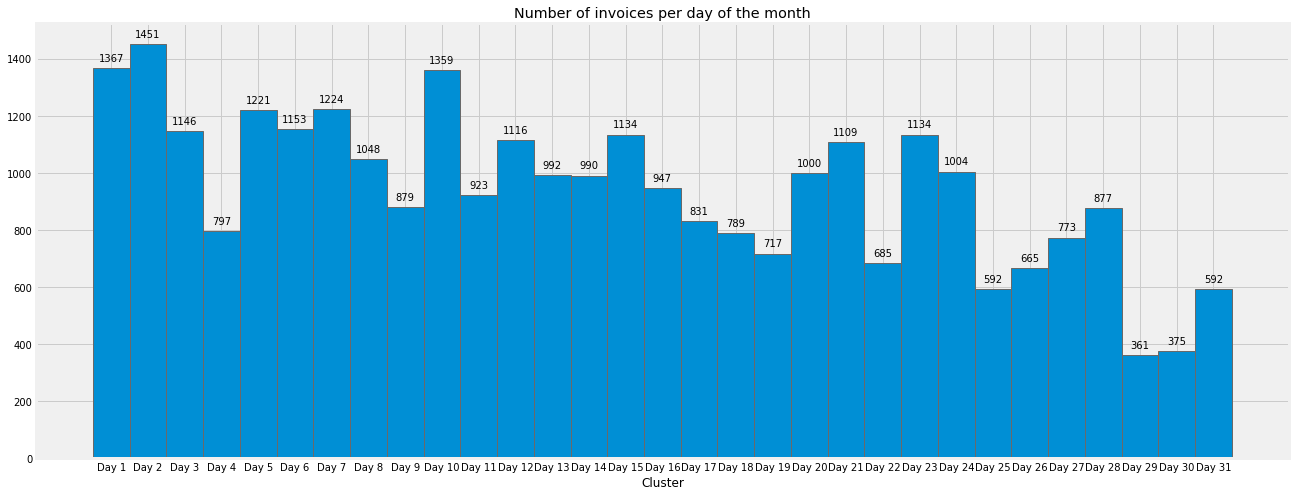

In [478]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [479]:
cluster5['Hour'].nunique()

14

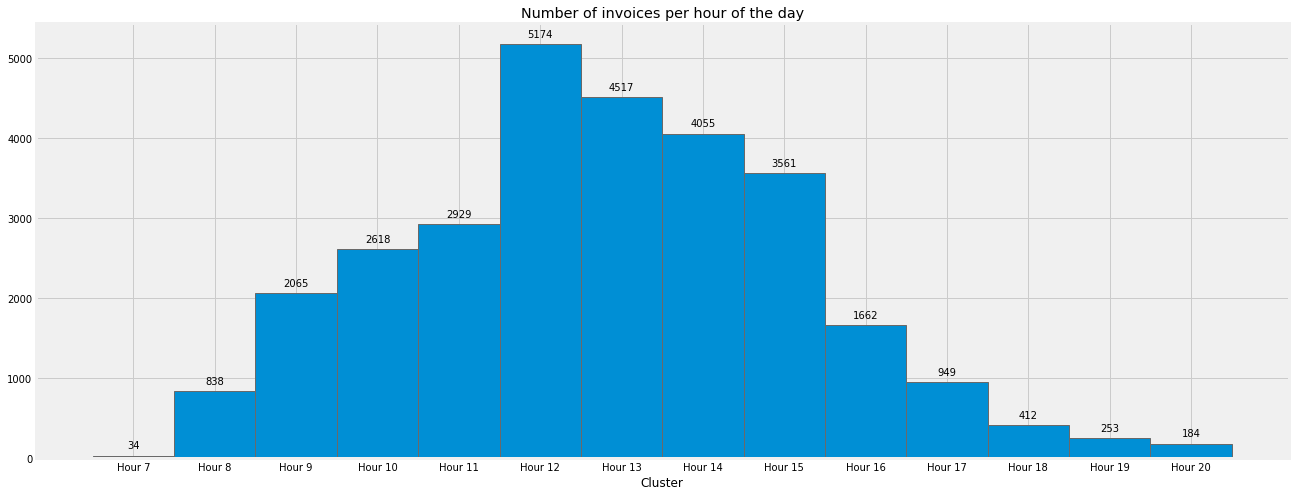

In [481]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster5['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster5['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

Key figures: 
* Min Basket Price:  32.98
* Mean Basket Price: 51.30
* Max Basket Price:  41.48

* Quantity:          9.48
* UnitPrice:         3.50
* Revenue:           17.26
* Frequency          2.60
* Recency            236.89

TOP 10 bought products :

* WHITE HANGING HEART T-LIGHT HOLDER    228
* REGENCY CAKESTAND 3 TIER              200
* PARTY BUNTING                         144
* ASSORTED COLOUR BIRD ORNAMENT         132
* JAM MAKING SET WITH JARS              112
* NATURAL SLATE HEART CHALKBOARD        105
* SET OF 3 CAKE TINS PANTRY DESIGN      105
* REX CASH+CARRY JUMBO SHOPPER          102
* HEART OF WICKER SMALL                  97
* PACK OF 72 RETROSPOT CAKE CASES        93